# 1. Weak strong error

In [2]:
# import libraries 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [48]:
# simulation using true formula and euler schema 
def simulation(X0, b, sigma, N, T, ax=None, names=None, title=None): 
    h = T/N 
    XE = np.empty(N+1)
    X = np.empty(N+1)
    Z = np.random.normal(0, 1, N)
    n = np.arange(1, N+1)
    XE[0] = X0
    X[0] = X0 
    # euler schema Xi+1 <- Xi*(b*h + sigma*sqrt(h)*Zi)
    XE[1:] = X0*np.cumprod(b*h+1+sigma*np.sqrt(h)*Z)  
    # True solution Xi+1 <- Xi*exp((b-sigma**2/2)*h + sigma*sqrt(h)*Zi)
    X[1:] = X0*np.cumprod(np.exp((b-sigma**2/2)*h + sigma*np.sqrt(h)*Z)) 
    if ax is None:
        plt.plot(h*np.arange(N+1), X) 
        plt.plot(h*np.arange(N+1), XE)
        plt.xlabel("t")
        plt.ylabel("X")
        plt.legend(["Euler", "Explicit Formula"])
        if title is not None: 
            plt.title(title)
    else: 
        ax.plot(h*np.arange(N+1), X, linewidth=2.5) 
        ax.plot(h*np.arange(N+1), XE)
        ax.set_xlabel("t")
        ax.set_ylabel("X")
        ax.legend(["Euler", "Explicit Formula"])
        ax.set_title("")
        if title is not None: 
            ax.set_title(title)
        


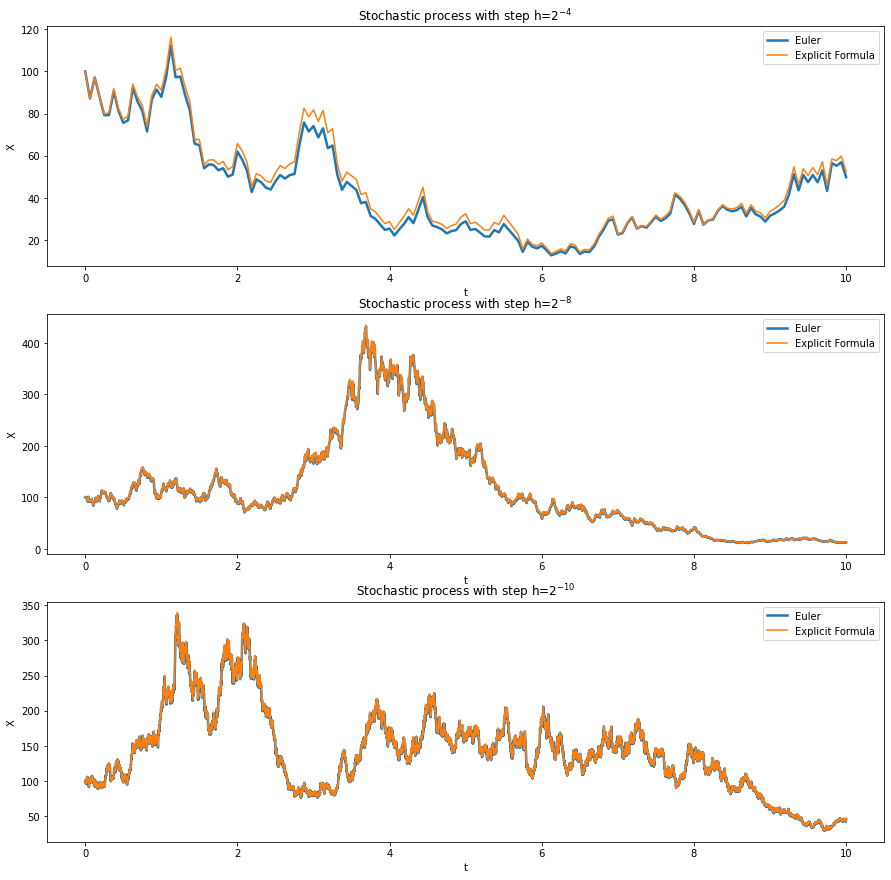

In [56]:
X0 = 100
b = 0.01
sigma = 0.5
T = 10
h = [2**-4, 2**-8, 2**-10]
names = ["$2^{-4}$", "$2^{-8}$", "$2^{-10}$"]
fig, axs = plt.subplots(3, figsize=(15, 15))
for index, v in enumerate(h):
    N = int(T/v)  
    title=f"Stochastic process with step h={names[index]}"
    simulation(X0, b, sigma, N, T, ax= axs[index], title=title )

In [50]:
# computing strong error
def strongError(X0, b, sigma, m, N, T):
    h = T/N
    XE = np.empty((N+1, m))
    XM = np.empty((N+1, m))
    X = np.empty((N+1, m)) 
    Z = np.random.normal(0, 1, (N, m))
    X[0, :] = X0
    XE[0, :] = X0
    XM[0, :] = X0 
    # euler approximation
    XE[1:] = X0*np.cumprod(b*h+1+sigma*np.sqrt(h)*Z, axis=0) 
    # Milstein approximation
    XM[1:] = X0*np.cumprod(b*h+1+sigma*np.sqrt(h)*Z + sigma**2*(h/2)*(Z**2 - 1), axis=0)
    # real value without approximation
    X[1:] = X0*np.cumprod(np.exp((b-sigma**2/2)*h + sigma*np.sqrt(h)*Z), axis=0) 
    # Calculating the mean of the max along the path for Milstein for various realisations
    strongErrorM = np.abs(XM-X).max(axis=0).mean()
    # Calculating the mean of the max along the path for Euler for various realisations
    strongErrorE = np.abs(XE-X).max(axis=0).mean()
    return strongErrorE, strongErrorM

Text(0, 0.5, 'log(strong error)')

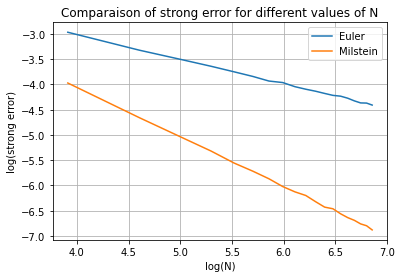

In [58]:
X0 = 100
b = 0.01
sigma = 0.02
T = 10
# different values of N 
N = np.arange(50, 1000, step=50)
# intilialize strong error for Euler 
strongErrorE = np.empty(len(N))
# intilialize strong error for Milstein
strongErrorM = np.empty(len(N))
for i, n in enumerate(N):
    strongErrorE[i], strongErrorM[i] = strongError(X0, b, sigma, 1000, n, T)
# ploting the log of the strong error
plt.plot(np.log(N), np.log(strongErrorE))
# ploting the log of the strong error
plt.plot(np.log(N), np.log(strongErrorM))
plt.grid()
plt.legend(["Euler", "Milstein"])
plt.title("Comparaison of strong error for different values of N")
plt.xlabel("log(N)")
plt.ylabel("log(strong error)")

In [55]:
# compute the slope of the two methods 
lg = LinearRegression()
lg.fit(np.log(N).reshape(-1, 1), np.log(strongErrorE))
print("The slope of the Euler schema: ", *lg.coef_)
lg.fit(np.log(N).reshape(-1, 1), np.log(strongErrorM))
print("The slope of the Milstein schema: ", *lg.coef_)

The slope of the Euler schema:  -0.49114205053591636
The slop of the Milstein schema:  -0.9834335091890799


In [3]:
# compute the error of the absolute difference between realisations of expectation based on Milstein and Euler 
# and the true expectation
def error(X0, b, sigma, n, m, N, T):
    eE=0
    eM=0
    for _ in range(m):
        h = T/N
        XTE = np.empty(n)
        XTM = np.empty(n)
        Z = np.random.normal(0, 1, (N, n))
        # compute XT for euler and Milstein
        XTE = X0*np.prod(b*h+1+sigma*np.sqrt(h)*Z, axis=0) 
        XTM = X0*np.prod(b*h+1+sigma*np.sqrt(h)*Z + sigma**2*(h/2)*(Z**2 - 1), axis=0)
        # true expectation
        EX1 = np.exp(b*T)*X0 
        # adding the error
        eE += abs(XTE.mean()-EX1)
        # adding the error
        eM += abs(XTM.mean()-EX1)
    eM /= m
    eE /= m 
    return eE, eM

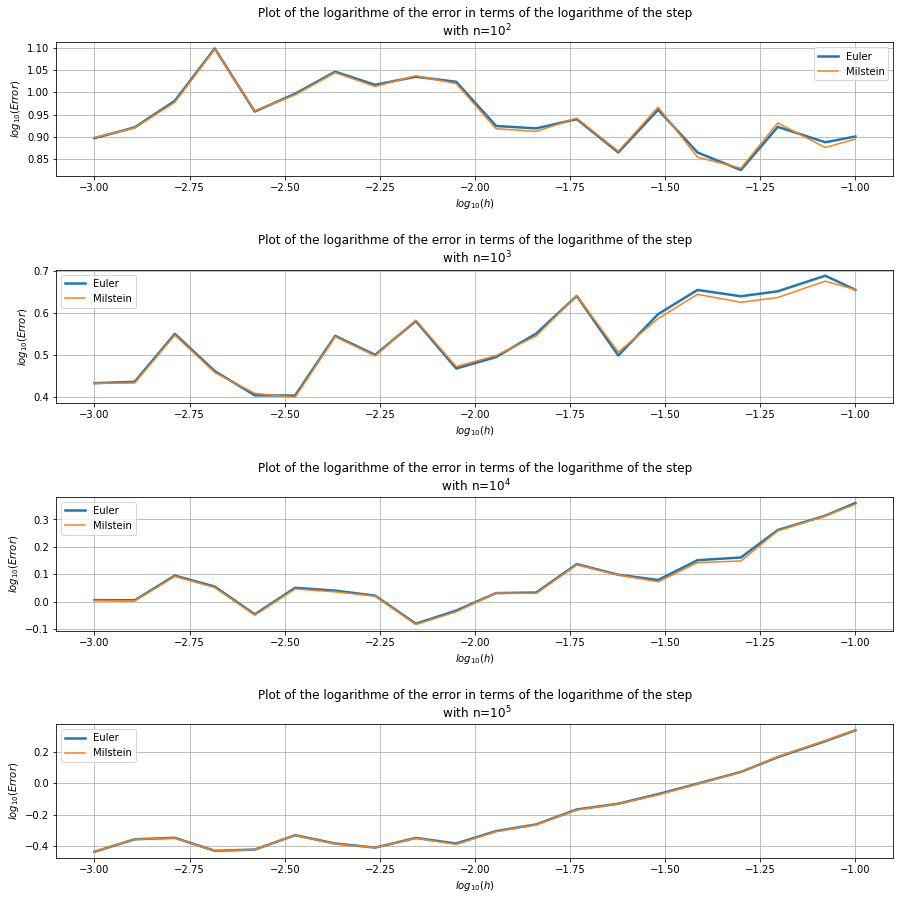

In [4]:
# cloud machine with 8 high performance processors and 32 Go
from multiprocessing import Pool
m = 100
b = 0.5
sigma = 0.6
X0 = 100
T = 1
# h varies from 0.1 to 0.001 with 20 points in the logarithme space 
N = np.logspace(1, 3, num=20).astype("int")
h = T/N

eM = np.zeros(len(N))
eE = np.zeros(len(N))
# compute 
powers = np.arange(2, 6)

# create a subplot of 5 plots 
fig, axs = plt.subplots(4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.7)
for index, power in enumerate(powers):
    n = 10**power 
    for i, Ni in enumerate(N):
        def computeerror(m):
            return error(X0, b, sigma, n, m, Ni, T)
        
        # divide the work into multiple processors   
        with Pool() as p:
            errors = p.map(computeerror, 10*[m//10])
            
        for ee, em in errors:
            eE[i] += ee 
            eM[i] += em
        # The obtained value is divided by 10 to account for the 10 results
        eE[i] /= 10
        eM[i] /= 10
    axs[index].plot(np.log10(h), np.log10(eE), linewidth=2.5)
    axs[index].plot(np.log10(h), np.log10(eM))
    axs[index].set_xlabel("$log_{10}(h)$")
    axs[index].set_ylabel("$log_{10}(Error)$")
    axs[index].set_title(f"Plot of the logarithme of the error in terms of the logarithme of the step\n with n=$10^{power}$")
    axs[index].grid()
    axs[index].legend(["Euler", "Milstein"])
fig.show()

# 2. Sensitivity of Option prices by the Monte-Carlo method

## 2.1. Finite difference estimation

In [337]:
# import libraries 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [338]:
# computing the finite differential values of delta and gamma
def Simulate_Hedge_FD(S0, r, sigma, T, N, eps, f, indepedant=False):
      
    Z = np.random.normal(0, 1, N)
    
    # simulation starting from S0 + eps
    SpEpsT = (S0 + eps)*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    
    # resimulate for each term in case of independence 
    if indepedant: 
        Z = np.random.normal(0, 1, N)
      
    # simulation starting from S0 
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    
    if indepedant: 
        Z = np.random.normal(0, 1, N)
        
    # simulation starting from S0 - eps
    SmEpsT = (S0 - eps)*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z) 
       
    # computing the expectations 
    Efp = f(SpEpsT).mean()
    Ef = f(ST).mean()
    Efm = f(SmEpsT).mean()
    delta = (Efp - Efm)/(2*eps)
    gamma = (Efp + Efm - 2*Ef)/(eps)**2
    return delta, gamma 

# the payoff function
def call(S, K, T): 
    return np.exp(-r*T)*np.maximum(S-K, 0) 

def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
# the true value of delta
def delta(S0, K, r, sigma, T): 
    return norm.cdf(d1(S0, K, r, sigma, T))

# the true value of gamma 
def gamma(S0, K, r, sigma, T): 
    return norm.pdf(d1(S0, K, r, sigma, T))/(S0*sigma*np.sqrt(T))

In [343]:
S0 = 100
K = 100
r = 0.02
sigma = 0.35
f = lambda S: call(S, K, T)
T = 1 
N = 10000
eps =  10
# independent realisations
delta_ind, gamma_ind = Simulate_Hedge_FD(S0, r, sigma, T, N, eps, f, indepedant=True)
# dependent realisations
delta_dep, gamma_dep = Simulate_Hedge_FD(S0, r, sigma, T, N, eps, f, indepedant=False)
print("True value of delta: :", delta(S0, K, r, sigma, T))
print("Approximated delta value with independent realisations: ", delta_ind)
print("Approximated delta value with dependent realisations: ", delta_dep)
print("True value of gamma: ", gamma(S0, K, r, sigma, T))
print("Approximated gamma value with independent realisations: ", gamma_ind)
print("Approximated gamma value with dependent realisations: ", gamma_dep)

True value of delta: : 0.5917864706261471
Approximated delta value with independent realisations:  0.6216947833798683
Approximated delta value with dependent realisations:  0.5918323662630398
True value of gamma:  0.011095321480532374
Approximated gamma value with independent realisations:  0.011534558221054887
Approximated gamma value with dependent realisations:  0.011238078302091914


In [345]:
# computing the variance 
def variance(S0, r, sigma, T, N, eps, indepedant=False):

    Z = np.random.normal(0, 1, N)
    
    SpEpsT = (S0 + eps)*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)

    if indepedant: 
        Z = np.random.normal(0, 1, N)
        
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)

    if indepedant: 
        Z = np.random.normal(0, 1, N)
        
    SmEpsT = (S0 - eps)*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z) 
    
    # compute realisations of the random variable 
    deltasim = (call(SpEpsT, K, T)-call(SmEpsT, K, T))
    
    # compute the realisations of the random variable 
    gammasim = (call(SpEpsT, K, T) + call(SmEpsT, K, T) - 2*call(ST, K, T))
    
    varDelta = np.std(deltasim, ddof=1)**2/(4*eps**2*N)
    varGamma = np.std(gammasim, ddof=1)**2/(N*eps**4)
    return varDelta, varGamma

In [350]:
# obtained values of the variance 
varDelta, varGamma = variance(S0, r, sigma, T, N, eps, indepedant=True)
print("variance of delta with independent relasations", varDelta)
print("variance of gamma with independent relasations", varGamma)
varDelta, varGamma = variance(S0, r, sigma, T, N, eps, indepedant=False)
print("variance of delta with dependent relasations", varDelta)
print("variance of gamma with dependent relasations", varGamma)

variance of delta with independent relasations 0.0003532757596257824
variance of gamma with independent relasations 4.1159990544826376e-05
variance of delta with dependent relasations 4.2853853985344637e-05
variance of gamma with dependent relasations 5.7949541689467285e-08


Text(0.5, 1.0, 'Variance of $\\Delta$ as a function of N')

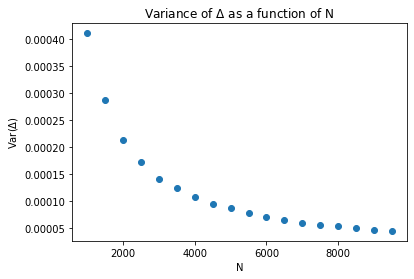

In [353]:
# ploting the variance as a function of N 
N = np.arange(1000, 10000, step=500)
varDelta = np.empty(len(N))
varGamma = np.empty(len(N))
for i, Ni in enumerate(N):
    varDelta[i], varGamma[i] = variance(S0, r, sigma, T, Ni, eps)
    
plt.scatter(N, varDelta)
plt.xlabel("N")
plt.ylabel("Var($\Delta$)")
plt.title("Variance of $\Delta$ as a function of N")

Text(0.5, 1.0, 'Variance of $\\Gamma$ as a function of N')

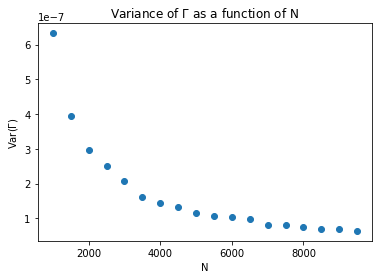

In [354]:
plt.scatter(N, varGamma)
plt.xlabel("N")
plt.ylabel("Var($\Gamma$)")
plt.title("Variance of $\Gamma$ as a function of N")

## 2.2. Estimation by flow technique

In [356]:
# the derivative of the payoff of the call
def Callprime(S, K, T): 
    return np.exp(-r*T)*(S>=K)

# simulation based on the flow method 
def Simulate_Hedge_Flow(S0, r, sigma, T, N, fprime):
    Z = np.random.normal(0, 1, N)   
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    delta = (fprime(ST)*ST).mean()/S0 
    return delta 

In [371]:
S0 = 100
K = 100
r = 0.02
sigma = 0.35
T = 1 
N = 10000
# delta obtained by the flow method 
fprime = lambda S: Callprime(S, K, T)
delta = Simulate_Hedge_Flow(S0, r, sigma, T, N, fprime)
print("Delta by flow method: ", delta)

Delta by flow method:  0.5950800280035561


In [372]:
# computing the variance of delta approximation 
def variance(S0, r, sigma, T, N, fprime):

    Z = np.random.normal(0, 1, N)
    
    WT = np.sqrt(T)*Z
        
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    
    deltasim = (fprime(ST)*ST)/S0
    
    varDelta = np.std(deltasim, ddof=1)**2/N
    
    return varDelta

In [373]:
vardelta = variance(S0, r, sigma, T, N, fprime)
print("Variance of delta of the flow technique: ", vardelta)

Variance of delta of the flow technique:  4.576239753479506e-05


## 2.3. Estimation by Malliavin calculus type approach

In [362]:
# computing delta and gamma based on the Milliavin method 
def Simulate_Hedge_Malliavin(S0, r, sigma, T, N, f, fprime):
    Z = np.random.normal(0, 1, N) 
    WT = np.sqrt(T)*Z
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    delta = (f(ST)*WT).mean()/(S0*sigma*T)
    gamma = (fprime(ST)*ST*WT).mean()- (f(ST)*WT).mean()
    gamma /= (S0**2*sigma*T)
    return delta, gamma 

In [375]:
# computing the variance 
def variance(S0, r, sigma, T, N, f, fprime):

    Z = np.random.normal(0, 1, N)
    
    WT = np.sqrt(T)*Z
        
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    
    deltasim = (f(ST)*WT)/(S0*sigma*T)
    
    varDelta = np.std(deltasim, ddof=1)**2/N
    
    gammasim = (fprime(ST)*ST*WT)- (f(ST)*WT)
    gammasim /= (S0**2*sigma*T)
    
    varGamma = np.std(gammasim, ddof=1)**2/N
    return varDelta, varGamma

In [381]:
S0 = 100
K = 100
r = 0.02
sigma = 0.35
T = 1 
N = 10000
f = lambda S: call(S, K, T)
fprime = lambda S: Callprime(S, K, T)
# the delta and gamma based on the Milliavin method 
deltaM, gammaM = Simulate_Hedge_Malliavin(S0, r, sigma, T, N, f, fprime)
print("Delta by Milliavin method: ", deltaM)
print("Gamma by Milliavin method: ", gammaM)

Delta by Milliavin method:  0.594675845170002
Gamma by Milliavin method:  0.01126063727826745


In [382]:
# the variance result 
vardeltaM, vargammaM = variance(S0, r, sigma, T, 10000, f, fprime)
print("Variance of delta of the Milliavin technique: ", vardeltaM)
print("Variance of gamma of the Milliavin technique: ", gammaM)

Variance of delta of the Milliavin technique:  0.00025341249103193165
Variance of gamma of the Milliavin technique:  0.01126063727826745


## 2.4. Variance reduction

### 2.4.1. Control variate

In [384]:
# the variance with the controle variate method
def variance(S0, r, sigma, T, N, fprime):
    Z = np.random.normal(0, 1, N)
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    b = -1*np.cov(fprime(ST)*ST/S0, ST)/np.std(ST)**2
    b = b[0, 1]
    
    deltasim = (fprime(ST)*ST)/S0 + b*ST
    varDelta = np.std(deltasim, ddof=1)**2/N
    return varDelta

In [385]:
S0 = 100
K = 100
r = 0.02
sigma = 0.35
T = 1 
N = 10000
# the variance obtained 
fprime = lambda S: Callprime(S, K, T)
vardelta = variance(S0, r, sigma, T, N, fprime)
print("Variance of gamma of the Milliavin technique: ", vardelta)

Variance of gamma of the Milliavin technique:  8.606812496786851e-06


### 2.4.2. Delta 

In [386]:
# the psiR function
def psiR(S, K, T, R): 
    return np.exp(-r*T)*(S-K)*(S>K+R) + np.exp(-r*T)*(S<=K+R)*(S>K-R)*(S - (K-R))**2/(4*R)

# the derivative of psi
def psiRprime(S, K, T, R):
    return np.exp(-r*T)*(S>K+R) + np.exp(-r*T)*(S<=K+R)*(S>K-R)*(S - (K-R))/(2*R)

# the psi function
def psi(S, K, T):
    return np.exp(-r*T)*np.maximum(S-K, 0)
    
# the variance of delta approximation
def varianceDelta(S0, K, R, r, sigma, T, N, f, fprime):
    Z = np.random.normal(0, 1, N) 
    WT = np.sqrt(T)*Z
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    deltasim = psiRprime(ST, K, T, R)*ST/S0 + (psi(ST, K, T) - psiR(ST, K, T, R))*WT/(S0*sigma*T)
    varDelta = np.std(deltasim, ddof=1)**2/N
    return varDelta

# the gamma variance 
def varianceGamma(S0, K, R, r, sigma, T, N, f, fprime):
    Z = np.random.normal(0, 1, N) 
    WT = np.sqrt(T)*Z
    ST = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)
    gammasim = psiRprime(ST, K, T, R)*ST*WT - psiR(ST, K, T, R)*WT
    gammasim += (psi(ST, K, T) - psiR(ST, K, T, R))*(WT**2/(sigma*T) - WT - 1/sigma)
    gammasim /= (S0**2*sigma*T)
    varGamma = np.std(gammasim, ddof=1)**2/N
    return varGamma

In [390]:
S0 = 100
K = 100
r = 0.02
sigma = 0.35
T = 1 
N = 10000
R = np.logspace(-2, 3, num=1000)
# the delta variance result as a function of R 
vardelta = np.empty(len(R))
for i, v in enumerate(R):
    vardelta[i] = varianceDelta(S0, K, v, r, sigma, T, N, f, fprime)

Text(0.5, 1.0, 'The evolution of the variance in terms of the value of R')

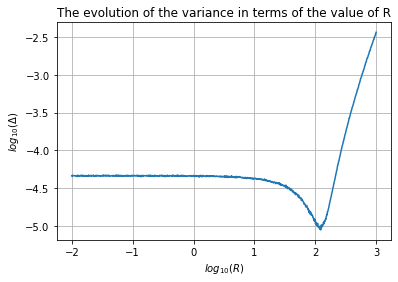

In [391]:
plt.plot(np.log10(R), np.log10(vardelta))
plt.grid()
plt.xlabel("$log_{10}(R)$")
plt.ylabel("$log_{10}(\Delta)$")
plt.title("The evolution of the variance in terms of the value of R")

In [393]:
print("the value where the minimum is reached for R: ", R[np.nanargmin(vardelta)])
print("the minimum value of the variance: ", vardelta.min())

the value where the minimum is reached for R:  122.76910479883604
the minimum value of the variance:  8.901104338059939e-06


In [394]:
S0 = 100
K = 100
r = 0.02
sigma = 0.35
T = 1 
N = 10000
R = np.logspace(-2, 3, num=1000)
vargamma = np.empty(len(R))
for i, v in enumerate(R):
    vargamma[i] = varianceGamma(S0, K, v, r, sigma, T, N, f, fprime)

Text(0.5, 1.0, 'The evolution of the variance in terms of the value of R')

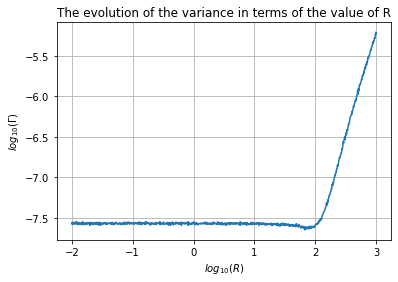

In [395]:
plt.plot(np.log10(R), np.log10(vargamma))
plt.grid()
plt.xlabel("$log_{10}(R)$")
plt.ylabel("$log_{10}(\Gamma)$")
plt.title("The evolution of the variance in terms of the value of R")

In [397]:
print("the value where the minimum is reached for R: ", R[np.nanargmin(vargamma)])
print("the minimum value of the variance: ", vargamma.min())

the value where the minimum is reached for R:  68.20776732865686
the minimum value of the variance:  2.2393823312906552e-08
